# EPIC-2037_Fitting+MCMC

Using EPIC-2037 (K2-24) dataset, we demonstrate how to

- perform a max-likelihood fit
- do an MCMC exploration of the posterior space



In [1]:
# Preliminary imports
%pylab inline
import radvel
reload(radvel.likelihood)
import radvel.plotting
import pandas as pd
import os
from scipy import optimize
import corner
rc('savefig',dpi=120)

/Users/bfulton/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load up EPIC-2037 data
path = os.path.join(radvel.DATADIR,'epic203771098.hdf')
planet = pd.read_hdf(path,'planet')
rv = pd.read_hdf(path,'rv')
def initialize_model():
    time_base = 2420
    params = radvel.RVParameters(2,basis='per tc secosw sesinw logk')
    params['per1'] = planet.ix['P','b']
    params['tc1'] = planet.ix['t0','b']
    params['secosw1'] = 0.01
    params['sesinw1'] = 0.01
    params['logk1'] = 1.1
    params['per2'] = planet.ix['P','c']
    params['tc2'] = planet.ix['t0','c']
    params['secosw2'] = 0.01
    params['sesinw2'] = 0.01
    params['logk2'] = 1.1
    mod = radvel.RVModel(params, time_base=time_base)
    mod.params['dvdt'] = -0.02
    mod.params['curv'] = 0.01
    return mod

t = np.array(rv.t)
vel = np.array(rv.vel)
errvel = rv.errvel
ti = linspace(rv.t.iloc[0]-5,rv.t.iloc[-1]+5,100)

In [3]:
# Convenience function to plot model and residuals
def plot_results(like):
    fig = gcf()
    errorbar(
        like.x, like.model(t)+like.residuals(), 
        yerr=like.yerr, fmt='o'
        )
    plot(ti, like.model(ti))
    fig.set_tight_layout(True)
    xlabel('Time')
    ylabel('RV')
    draw()

Fit EPIC-2307 light curve
=========================
1. circular orbits
2. fixed period, time of transit

In [4]:
# Set initial values of the parameters
mod = initialize_model()
like = radvel.likelihood.RVLikelihood(mod, t, vel, errvel)
like.params['gamma'] = 0.1
like.params['logjit'] = 0.0
like

parameter                          value       vary
curv                                0.01       True
dvdt                               -0.02       True
gamma                                0.1       True
logjit                                 0       True
logk1                                1.1       True
logk2                                1.1       True
per1                             20.8851       True
per2                             42.3638       True
secosw1                             0.01       True
secosw2                             0.01       True
sesinw1                             0.01       True
sesinw2                             0.01       True
tc1                               2072.8       True
tc2                              2082.62       True

parameter                          value       vary
curv                                0.01       True
dvdt                               -0.02       True
gamma                                0.1       True
logjit                                 0       True
logk1                                1.1       True
logk2                                1.1       True
per1                             20.8851      False
per2                             42.3638      False
secosw1                             0.01      False
secosw2                             0.01      False
sesinw1                             0.01      False
sesinw2                             0.01      False
tc1                               2072.8      False
tc2                              2082.62      False



/Users/bfulton/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


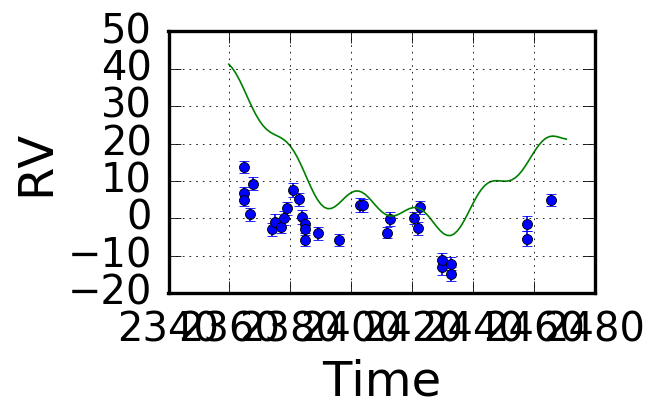

In [5]:



# Determin which parameters vary and which do not
like.vary['secosw1'] = False
like.vary['sesinw1'] = False
like.vary['secosw2'] = False
like.vary['sesinw2'] = False
like.vary['per1'] = False
like.vary['per2'] = False
like.vary['tc1'] = False
like.vary['tc2'] = False
like.vary['curv'] = True

figure()
plot_results(like) # Plot initial model
print like

parameter                          value       vary
curv                          0.00177421       True
dvdt                          -0.0309489       True
gamma                           -3.97501       True
logjit                           1.00948       True
logk1                            1.54751       True
logk2                            1.37979       True
per1                             20.8851      False
per2                             42.3638      False
secosw1                             0.01      False
secosw2                             0.01      False
sesinw1                             0.01      False
sesinw2                             0.01      False
tc1                               2072.8      False
tc2                              2082.62      False
Priors
------
Gaussian Prior on logjit, mu=1.09861228867, sigma=0.5
Gaussian Prior on logk2, mu=1.60943791243, sigma=10
Gaussian Prior on logk1, mu=1.60943791243, sigma=10
Gaussian Prior on gamma, mu=0, sigma=10



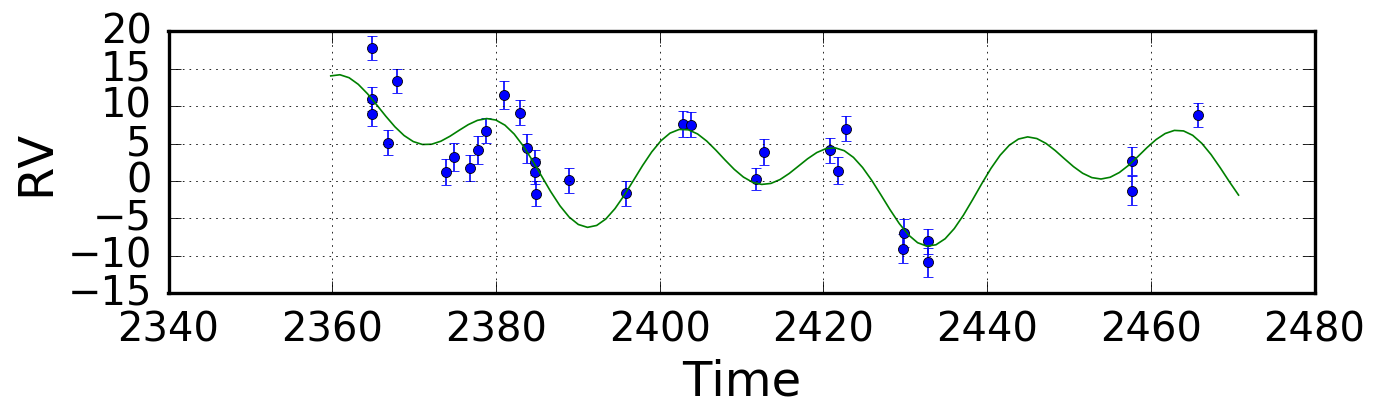

In [6]:
post = radvel.posterior.Posterior(like)
post.priors += [radvel.prior.Gaussian( 'logjit', log(3), 0.5)]
post.priors += [radvel.prior.Gaussian( 'logk2', log(5), 10)]
post.priors += [radvel.prior.Gaussian( 'logk1', log(5), 10)]
post.priors += [radvel.prior.Gaussian( 'gamma', 0, 10)]

res  = optimize.minimize(
    post.neglogprob_array, # objective function is negative log likelihood
    post.get_vary_params(), # initial variable parameters
    method='Powell', # Nelder-Mead also works
    )

#print res
#print like_syn
fig = figsize(12,4)
plot_results(like) # plot best fit model
print post

Performing burn-in...
Discarding burn-in


MCMC: WARNING: chains did not pass 5 consecutive convergence tests. They may be marginally well=mixed.


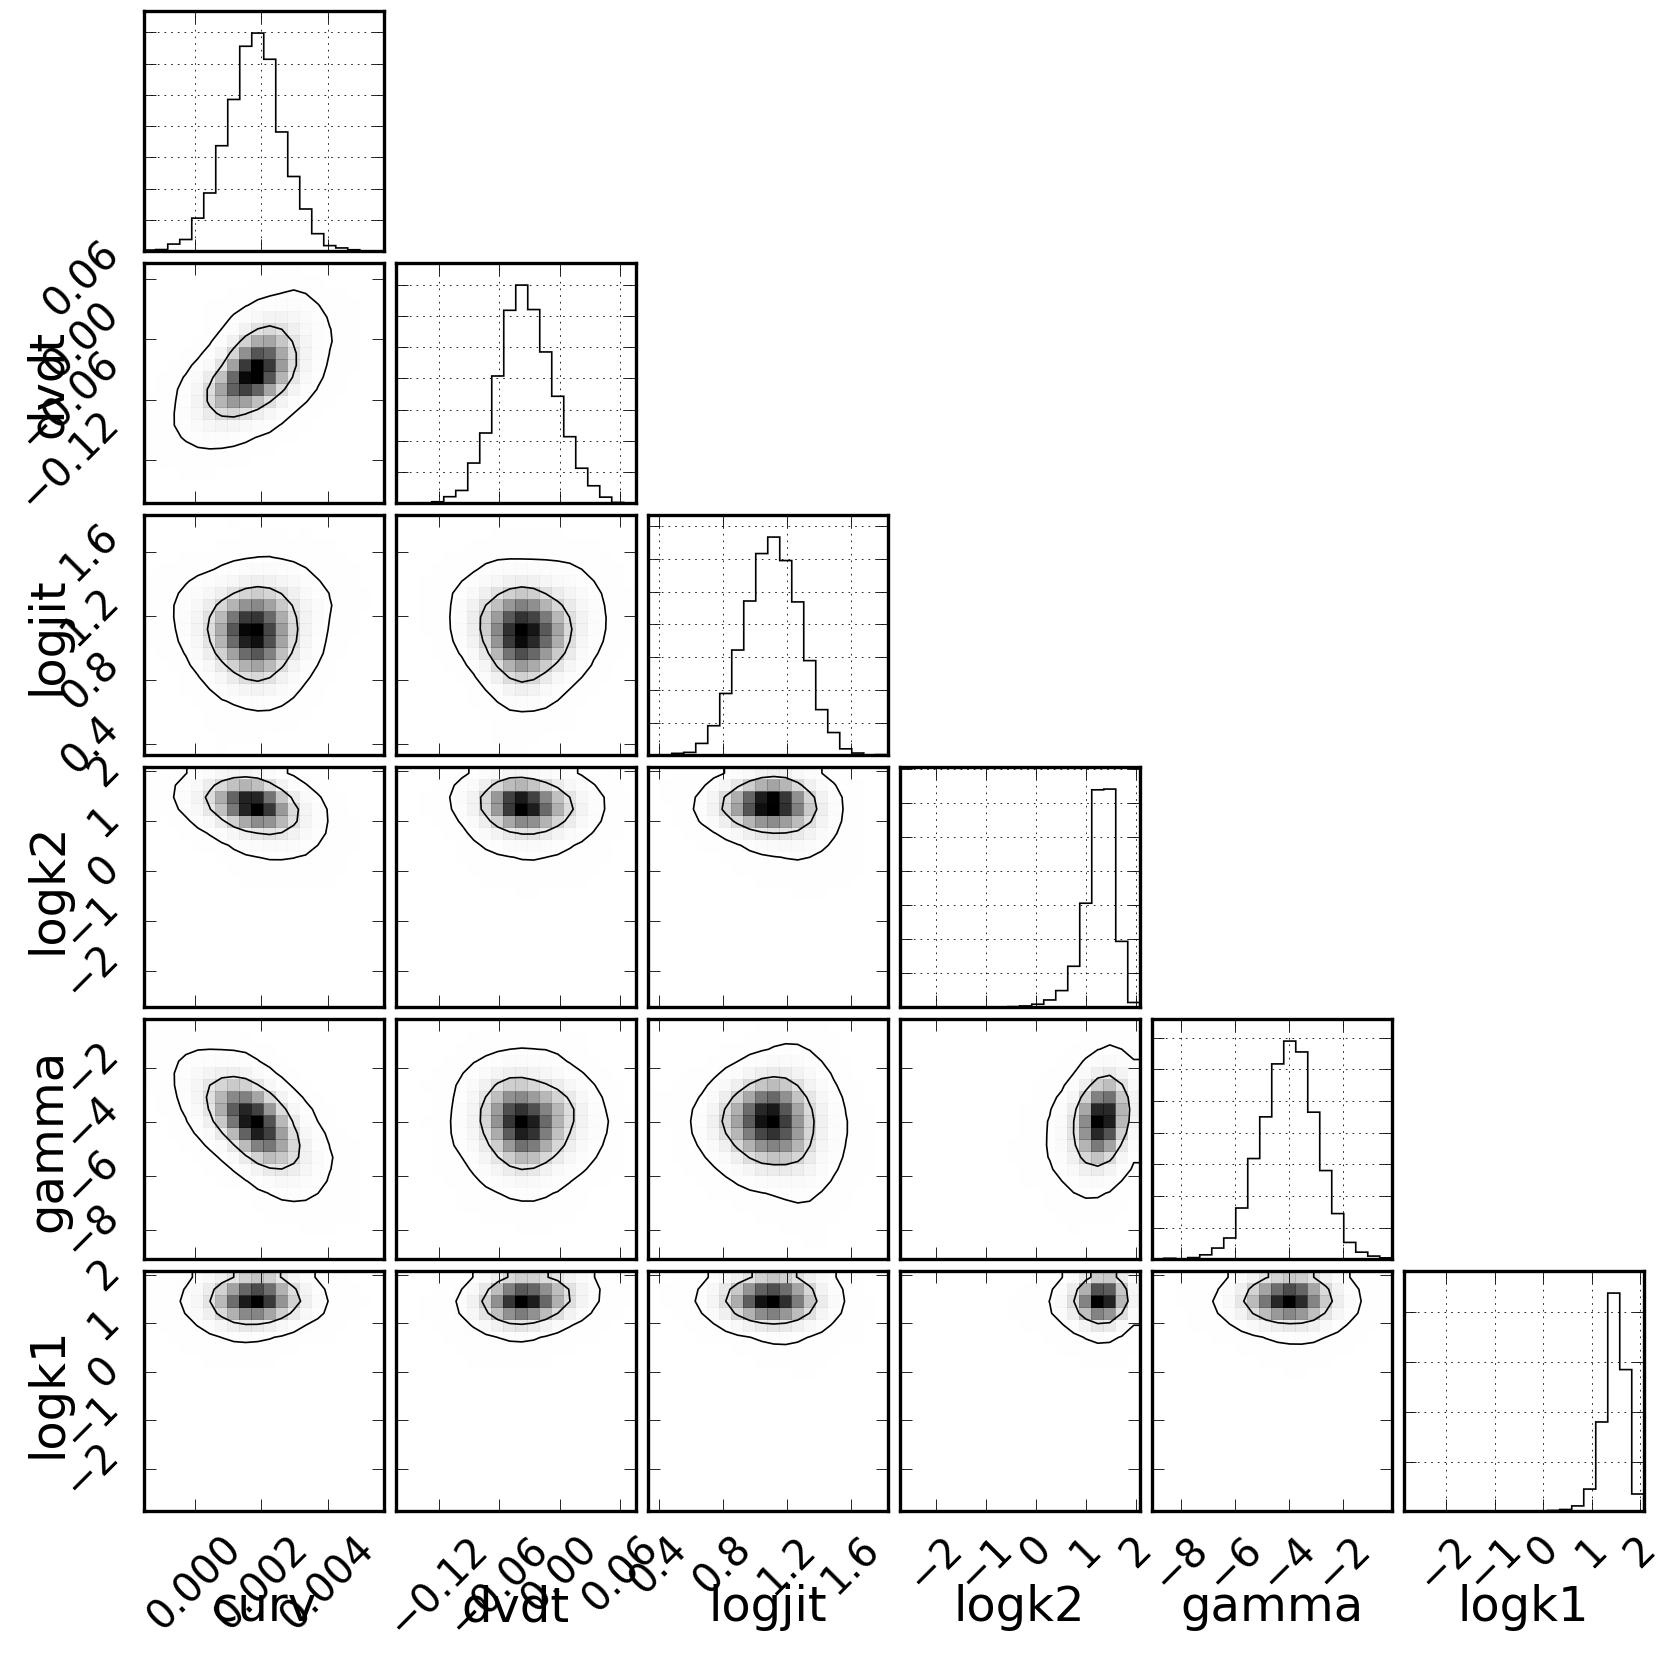

In [7]:
df = radvel.mcmc(post,threads=1,nburn=1000,nwalkers=20,nrun=1000)
labels = [k for k in post.vary.keys() if post.vary[k]]
fig = corner.corner(
    df[labels],
    labels=labels,
    levels=[0.68,0.95],
    plot_datapoints=False,
    smooth=True,
    bins=20
    )

/Users/bfulton/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


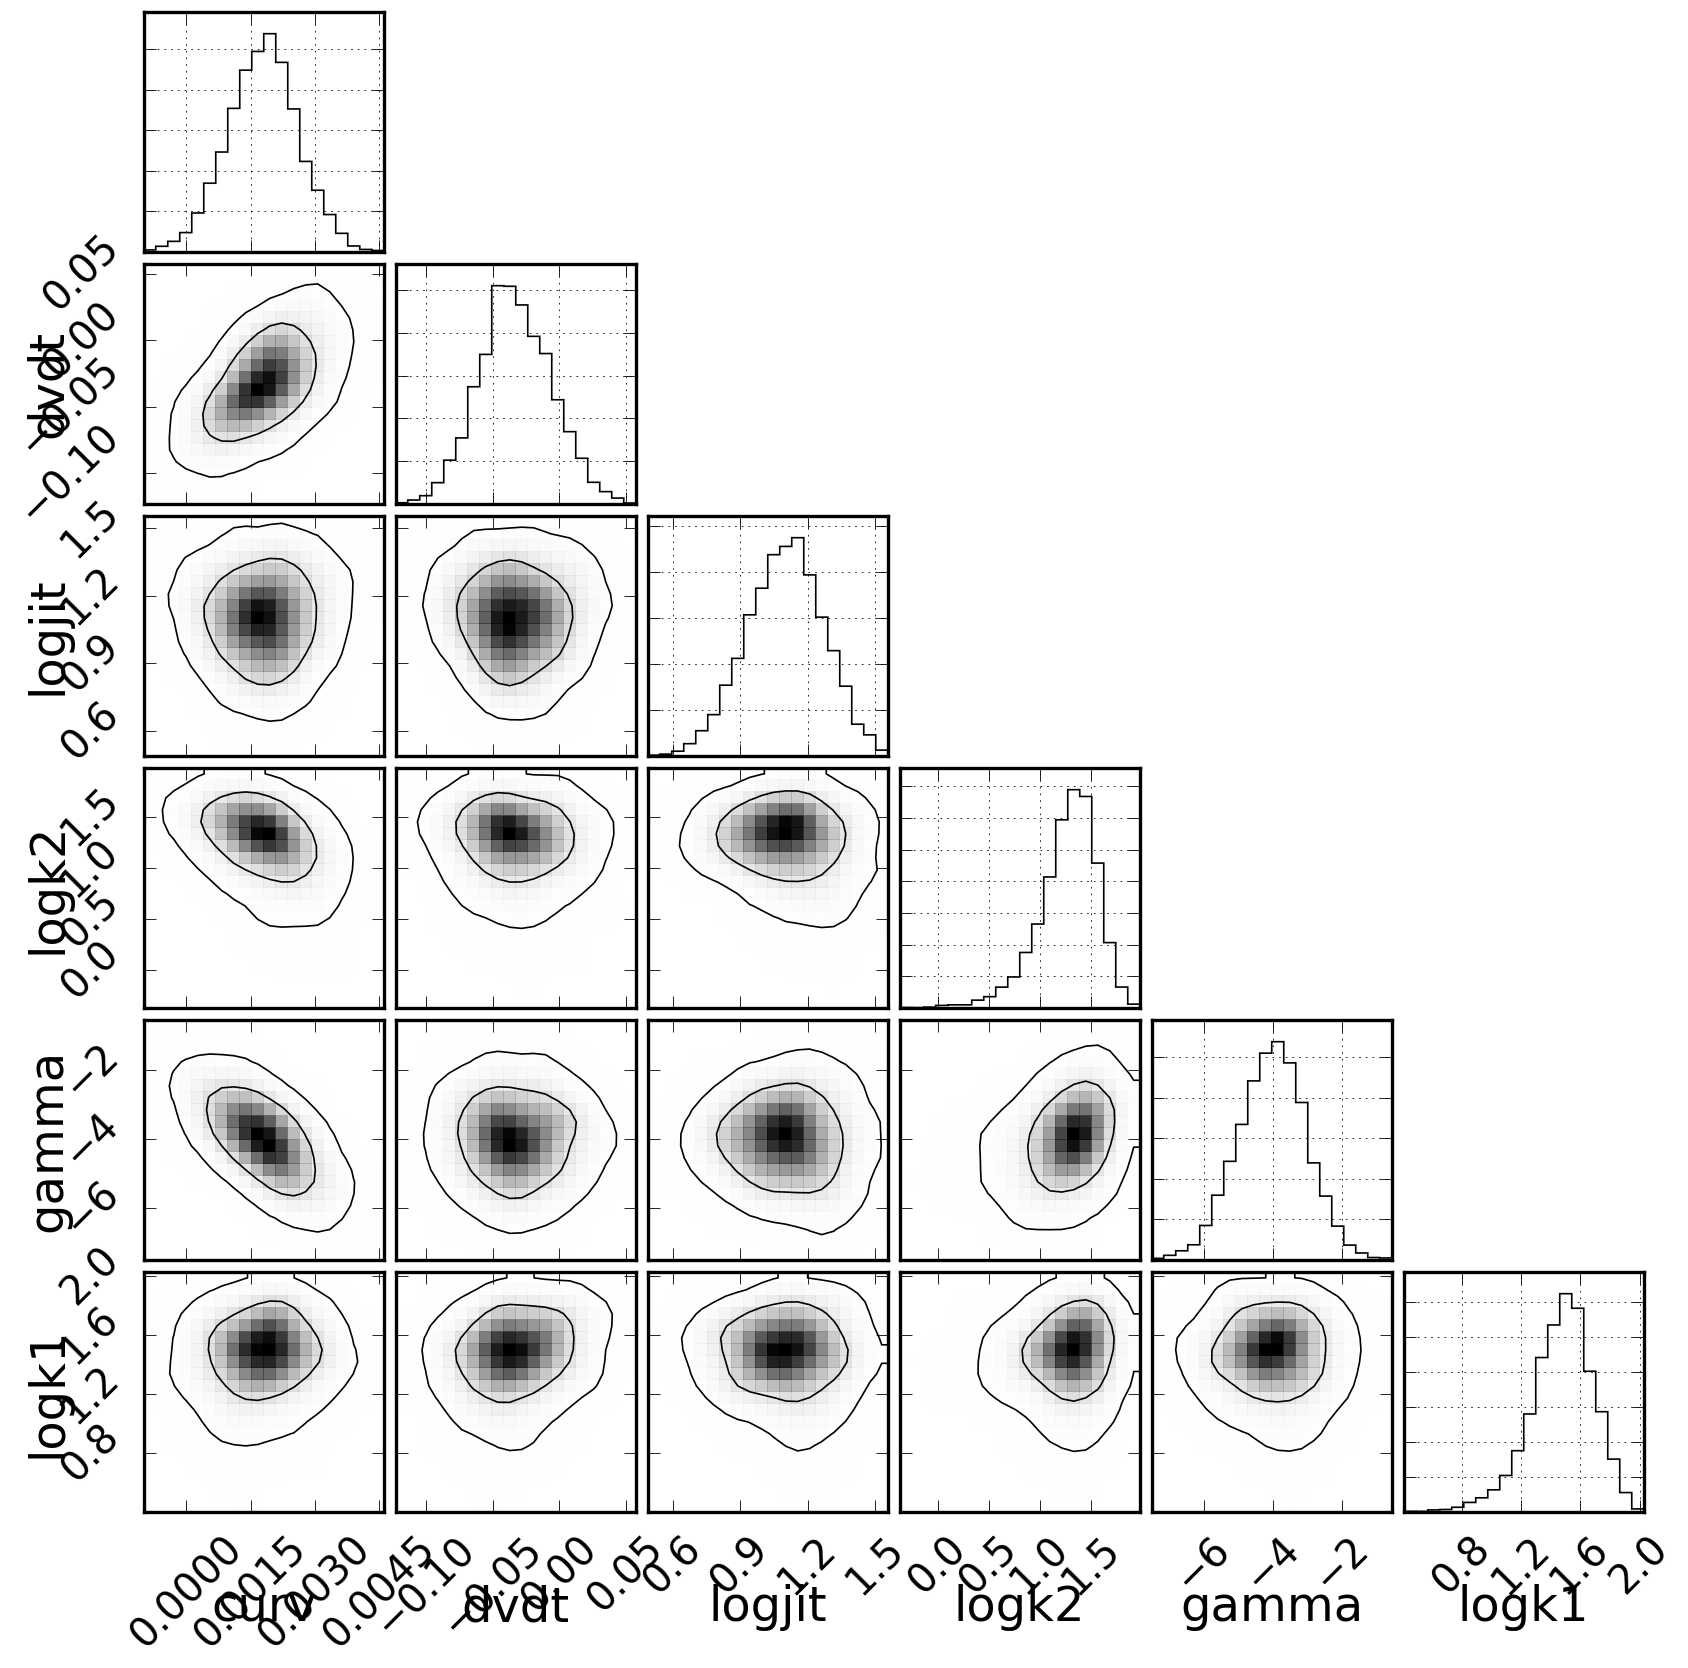

In [8]:
labels = [k for k in post.vary.keys() if post.vary[k]]
fig = corner.corner(
    df.sort('lnprobability').iloc[1000:][labels],
    labels=labels,
    levels=[0.68,0.95],
    plot_datapoints=False,
    smooth=True,
    bins=20
    )

Fit EPIC-2307 light curve
=========================
1. eccentric orbits
2. fixed period, time of transit

parameter                          value       vary
curv                                0.01       True
dvdt                               -0.02       True
gamma                                0.1       True
logjit                          0.693147       True
logk1                                1.1       True
logk2                                1.1       True
per1                             20.8851      False
per2                             42.3638      False
secosw1                              0.1       True
secosw2                              0.1       True
sesinw1                              0.1       True
sesinw2                              0.1       True
tc1                               2072.8      False
tc2                              2082.62      False



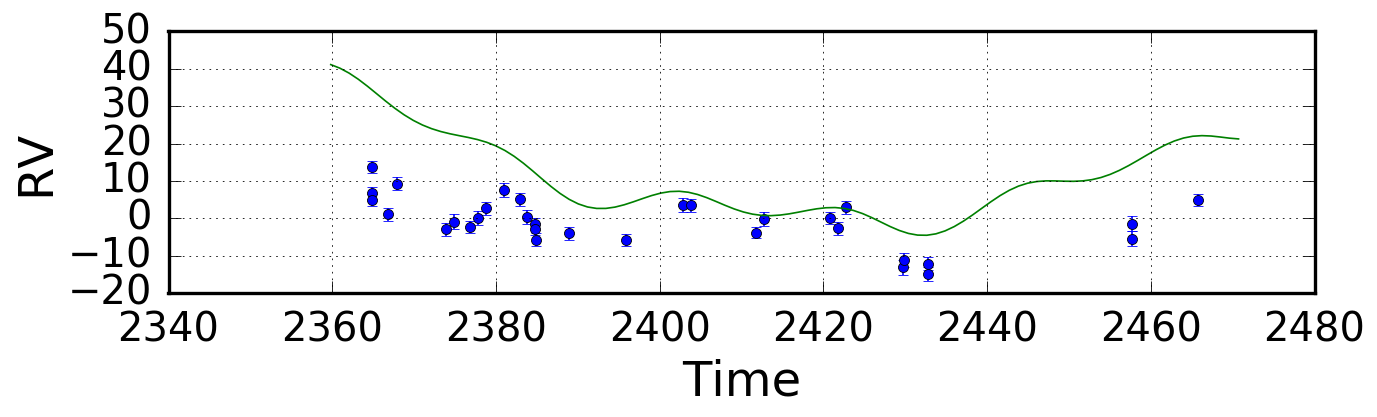

In [9]:
mod = initialize_model()
like = radvel.likelihood.RVLikelihood(mod, array(rv.t), array(rv.vel), array(rv.errvel))

# Eccentric orbits
like.params['gamma'] = 0.1
like.params['logjit'] = np.log(2)

# Some syntactic sugar to update multiple fields at once
like.vary.update(per1=False,per2=False,tc1=False,tc2=False)
like.params.update(secosw1=0.1,sesinw1=0.1,secosw2=0.1,sesinw2=0.1)
plot_results(like) # plot best fit model
print like

parameter                          value       vary
curv                        -0.000469413       True
dvdt                          -0.0241086       True
gamma                         -0.0616716       True
logjit                          0.833057       True
logk1                            1.65743       True
logk2                             1.7824       True
per1                             20.8851      False
per2                             42.3638      False
secosw1                         0.464122       True
secosw2                        0.0971677       True
sesinw1                        0.0988472       True
sesinw2                        0.0151221       True
tc1                               2072.8      False
tc2                              2082.62      False
Priors
------
Eccentricity constrained to be < 1
Gaussian Prior on logjit, mu=0.69314718056, sigma=0.1



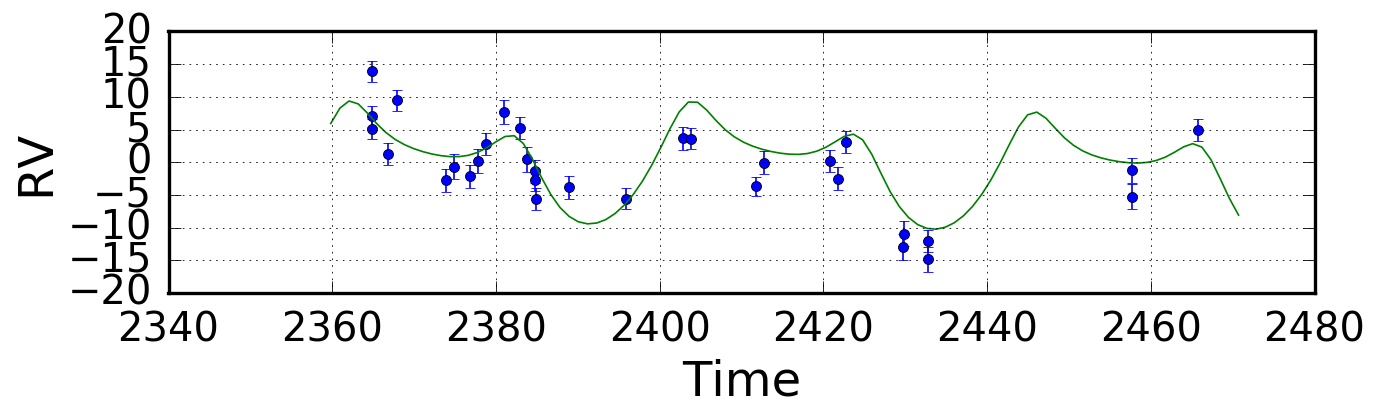

In [10]:
post = radvel.posterior.Posterior(like)
post.priors += [radvel.prior.EccentricityPrior( 2 )]
post.priors += [radvel.prior.Gaussian( 'logjit', log(2),0.1)]

#plot_results(like) # Plot initial model
res  = optimize.minimize(
    post.neglogprob_array, 
    post.get_vary_params(), 
    method='Nelder-Mead',)

plot_results(like) # plot best fit model
print post

Performing burn-in...
Discarding burn-in


MCMC: WARNING: chains did not pass convergence tests. They are likely not well-mixed.


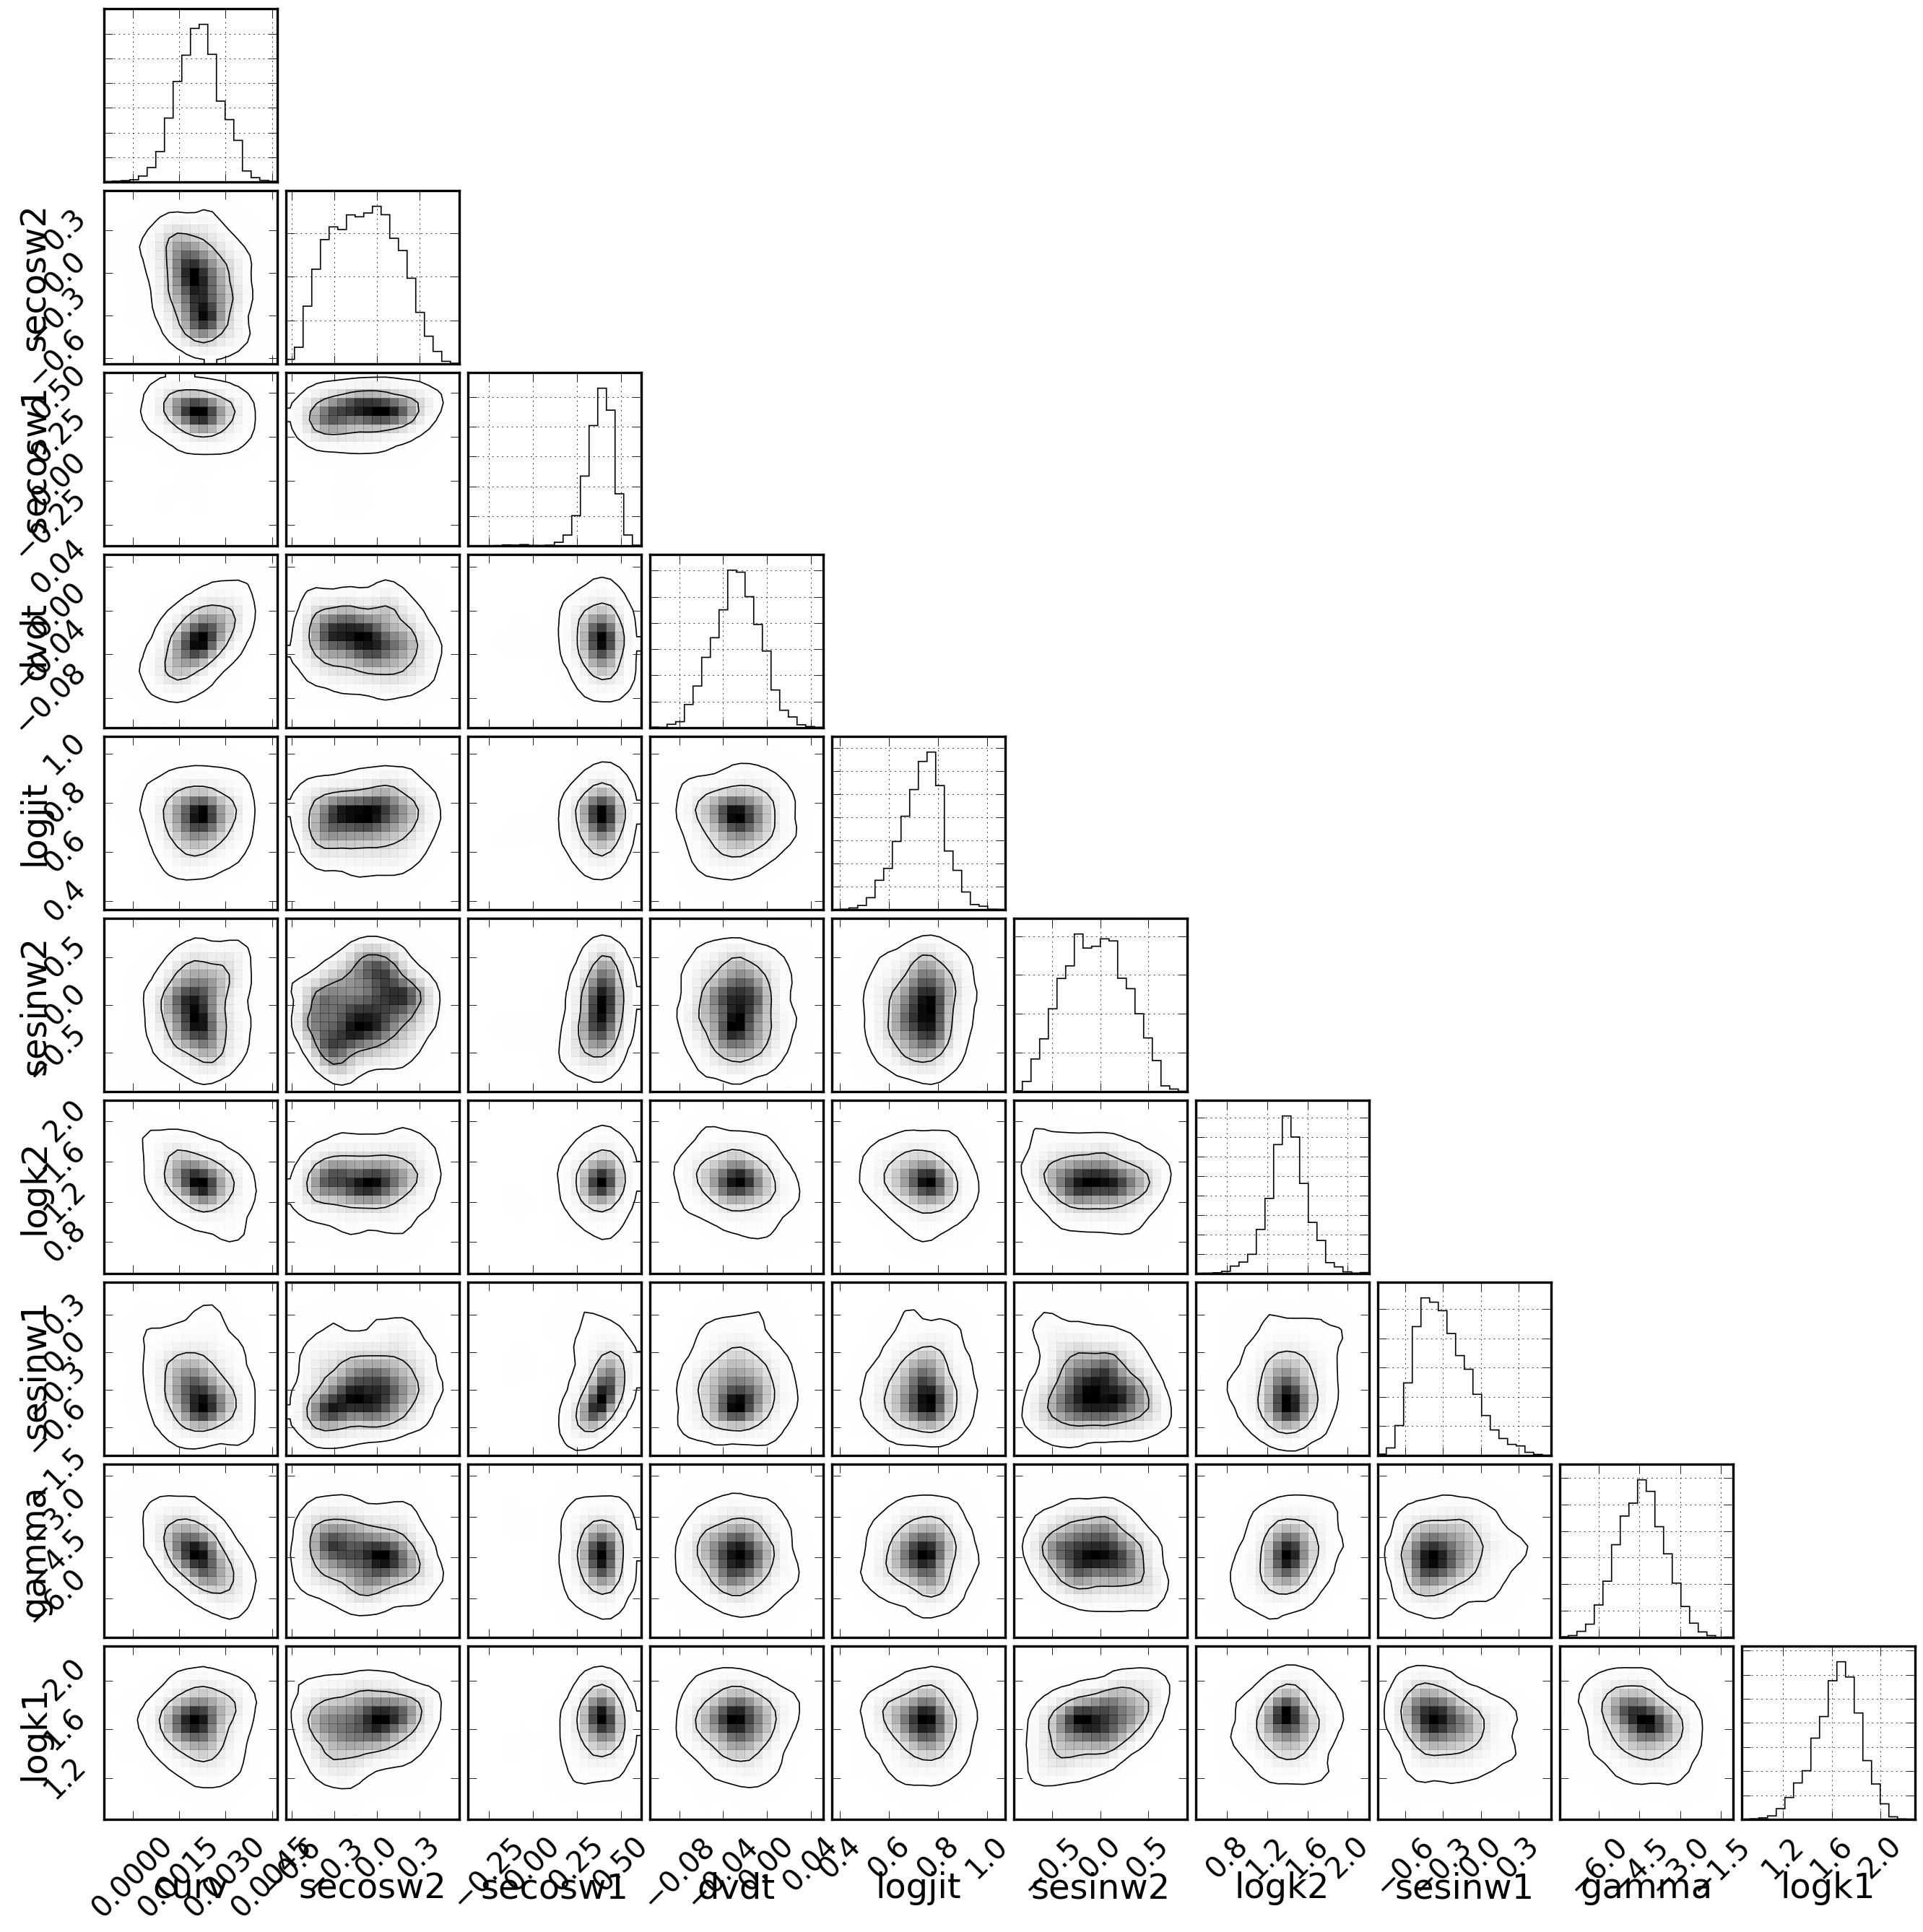

In [11]:
df = radvel.mcmc(post,threads=1,nburn=1000,nwalkers=20,nrun=1000)
labels = [k for k in post.vary.keys() if post.vary[k]]
fig = corner.corner(
    df[labels],labels=labels,levels=[0.68,0.95],plot_datapoints=False,smooth=True,bins=20
    )

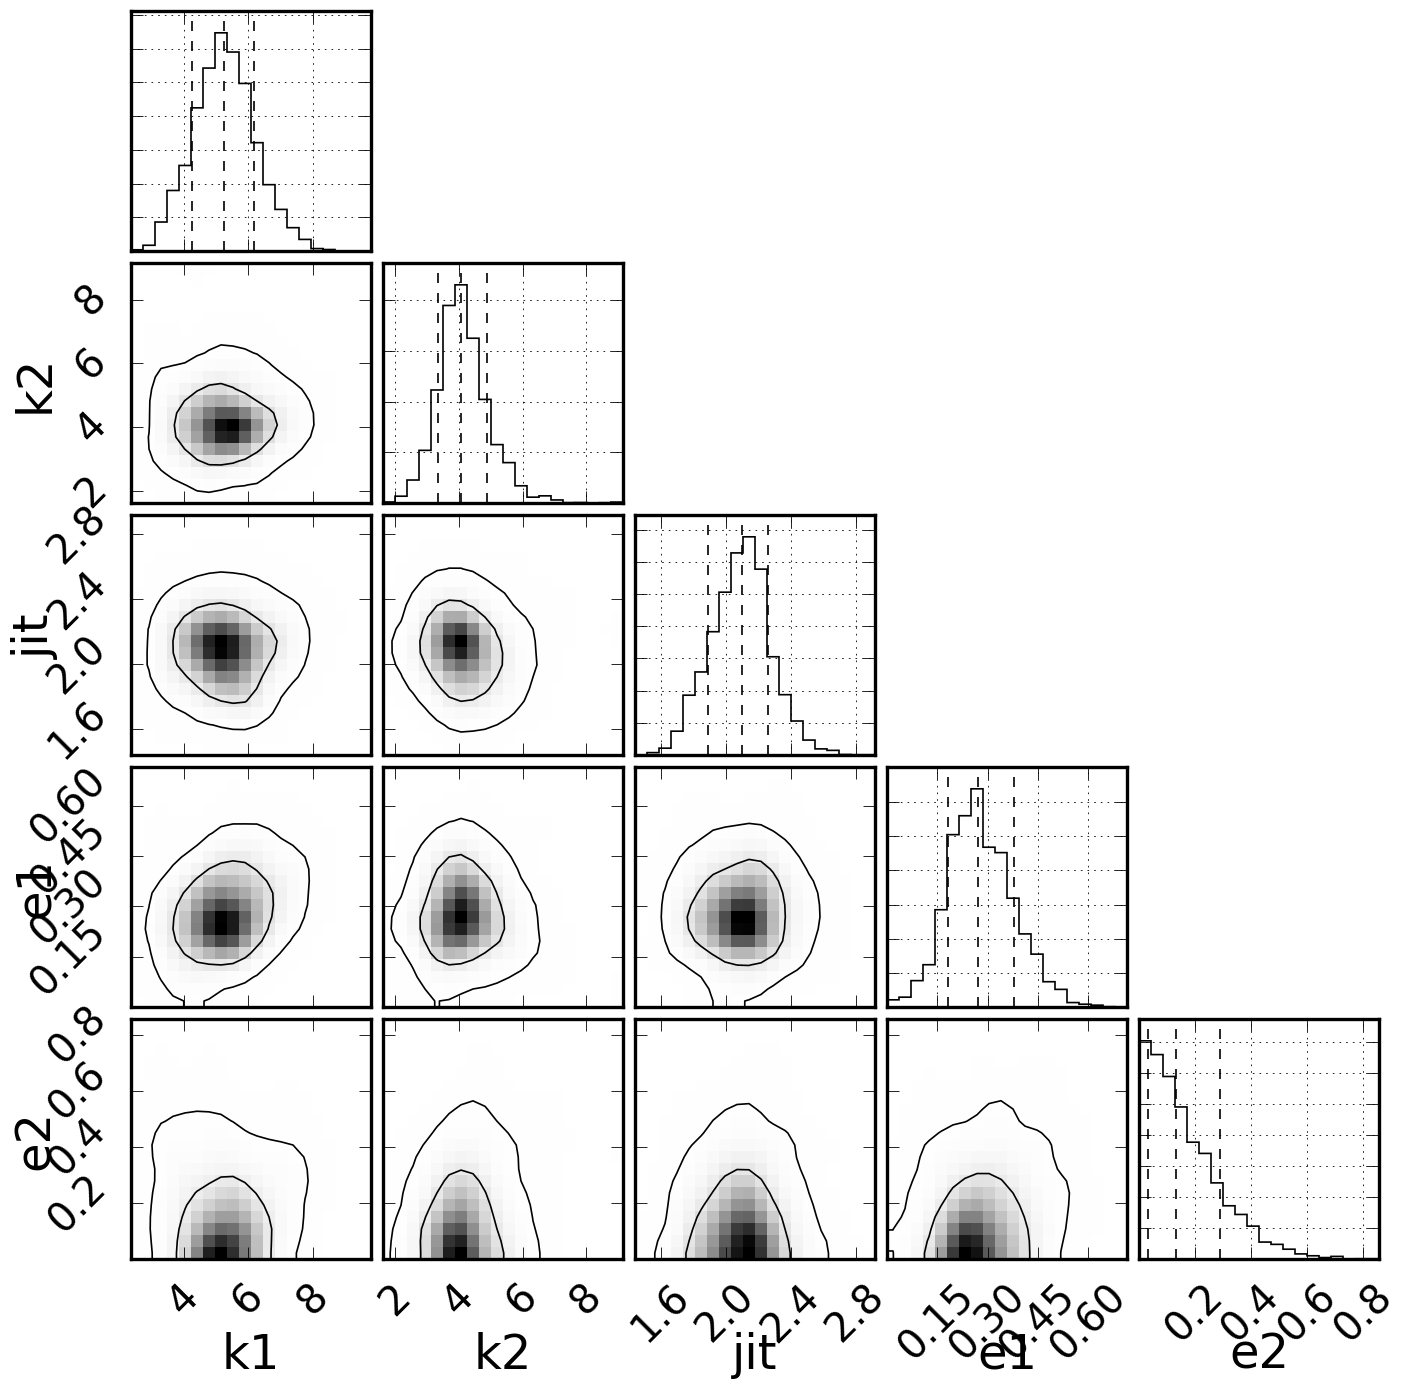

In [12]:
df['k1'] = exp(df['logk1'])
df['k2'] = exp(df['logk2'])
df['jit'] = exp(df['logjit'])
df['e1'] = df['secosw1']**2 + df['sesinw1']**2
df['e2'] = df['secosw2']**2 + df['sesinw2']**2

df['ecosw1'] = df['secosw1']*np.sqrt(df['e1'])
df['esinw1'] = df['sesinw1']*np.sqrt(df['e1'])

df['ecosw2'] = df['secosw2']*np.sqrt(df['e2'])
df['esinw2'] = df['sesinw2']*np.sqrt(df['e2'])


labels = 'k1 k2 jit e1 e2'.split()
fig = corner.corner(
    df[labels],
    labels=labels,
    levels=[0.68,0.95],
    plot_datapoints=False,
    smooth=True,
    bins=20,
    quantiles=[.14,.5,.84]
    )

In [13]:
df[labels].describe()

,k1,k2,jit,e1,e2
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,5.269702,4.148129,2.092193,0.280959,0.163403
std,0.954704,0.815324,0.184551,0.098345,0.130542
min,2.363332,1.625723,1.441497,0.000616,0.000075
25%,4.619793,3.636610,1.967487,0.212480,0.060047
50%,5.259594,4.065260,2.100621,0.271832,0.132388
75%,5.889686,4.583141,2.210925,0.344529,0.235655
max,9.803173,9.144428,2.919726,0.715084,0.855614


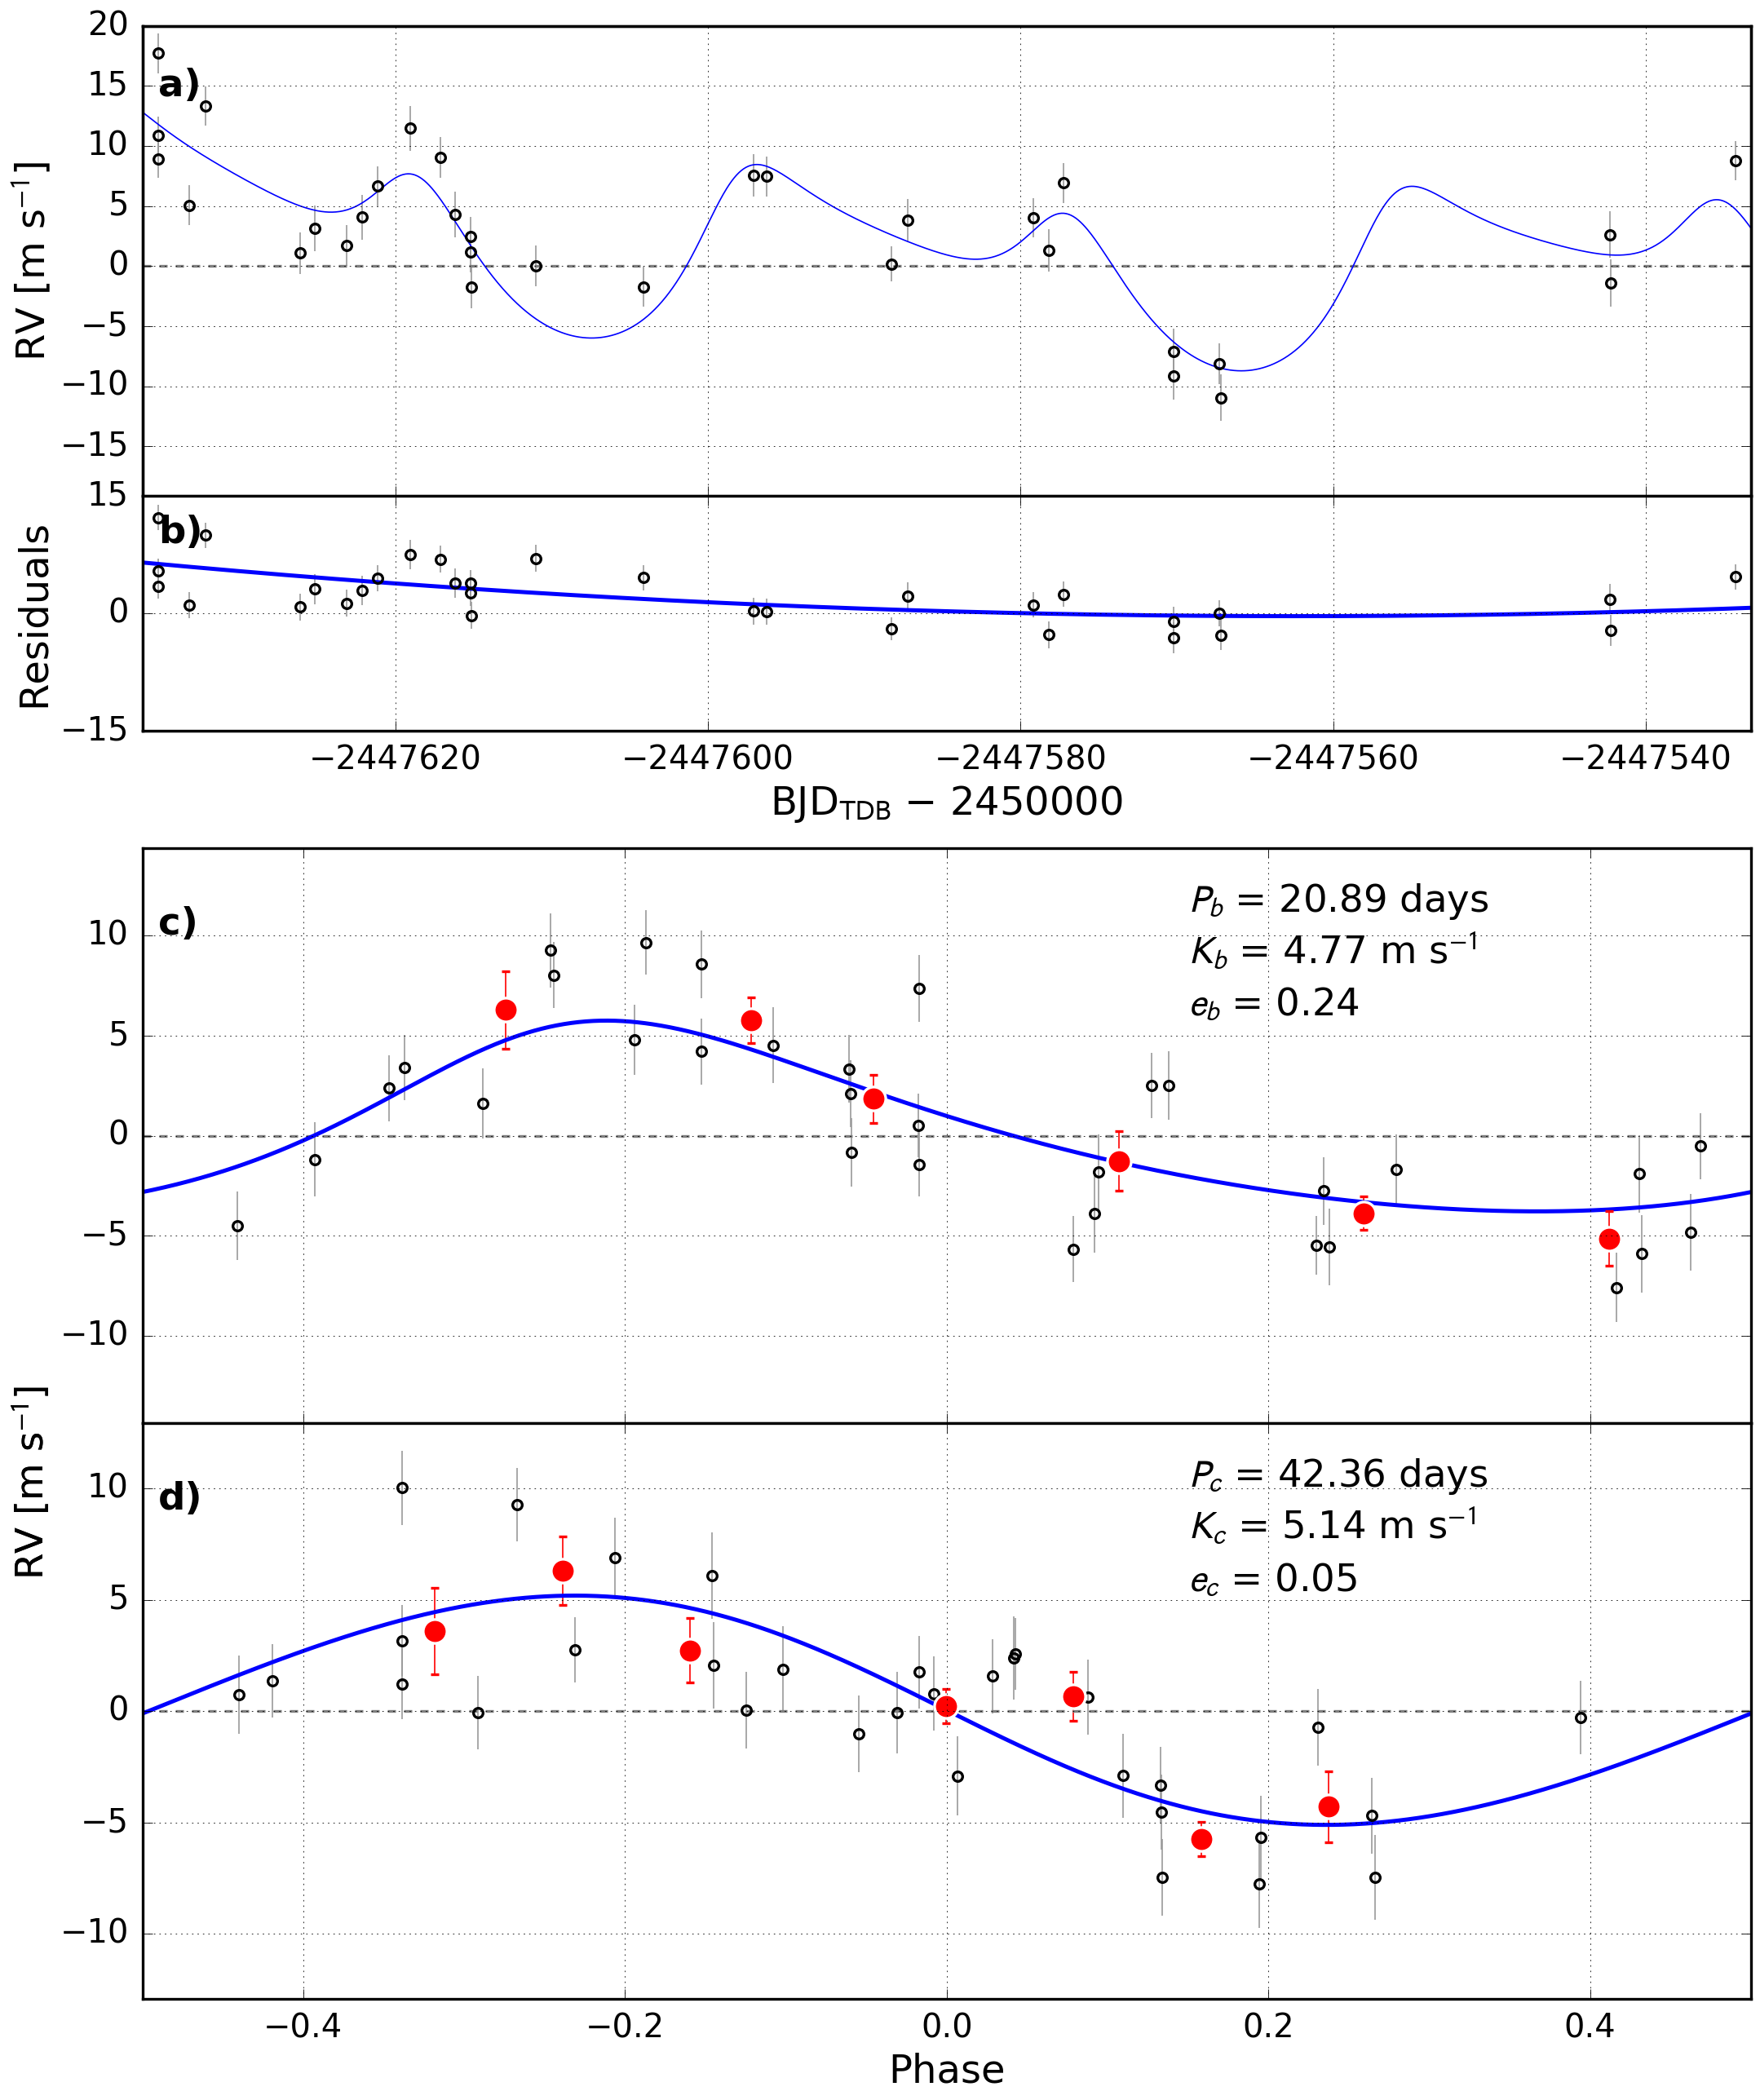

In [14]:
radvel.plotting.rv_multipanel_plot(post)